In [1]:
# train validation
experiment='stidedcnn_5cnn'
print experiment

stidedcnn_5cnn


In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline  
import cv2

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import time
#from funcs import model_basic as model_basic
import os
print 'All libs successfully loaded!'
from funcs.image import ImageDataGenerator
from funcs import utils
from funcs import misc

# current working directory
#print os.getcwd() 

path2set="../dcom/TrainingSet/"
path2numpy = path2set+"numpy/"
path2nfolds=path2numpy+'nfolds/'
foldnm=1

# fix random seed for reproducibility
seed = 2016
np.random.seed(seed)

# configure plotting
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Using Theano backend.


All libs successfully loaded!


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [3]:
# functions
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Dropout,AtrousConvolution2D
from keras.layers.advanced_activations import ELU
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.models import Sequential

def dice_coef(y_true, y_pred):
    smooth=1
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# model
def cnn_model(params):

    h=params['row']
    w=params['col']
    lr=params['learning_rate']
    weights_path=params['weights']
    lossfunc=params['loss']
    
   
    inputs = Input((1, h, w))
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(16, 3, 3, activation='relu',subsample=(2,2), border_mode='same')(conv1)
    #pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #model = Model(input=inputs, output=pool1)
    #print 'output pool1: ', model.output_shape
    
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv2 = Convolution2D(32, 3, 3, activation='relu',subsample=(2,2), border_mode='same')(conv2)
    #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #model = Model(input=inputs, output=pool2)
    #print 'output pool2: ', model.output_shape

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    conv3 = Convolution2D(64, 3, 3, activation='relu',subsample=(2,2), border_mode='same')(conv3)
    #pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #model = Model(input=inputs, output=pool3)
    #print 'output pool3: ', model.output_shape

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    conv4 = Convolution2D(128, 3, 3, activation='relu',subsample=(2,2), border_mode='same')(conv4)
    #pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #model = Model(input=inputs, output=conv4)
    #print 'output conv4: ', model.output_shape

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv4)
    conv4 = Convolution2D(128, 3, 3, activation='relu',subsample=(2,2), border_mode='same')(conv4)

    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv5)
    #model = Model(input=inputs, output=conv5)
    #print 'output conv4: ', model.output_shape
    
    # drop out
    conv5=Dropout(.5) (conv5)
    model = Model(input=inputs, output=conv5)

    up55 = UpSampling2D(size=(2, 2))(conv5)
    deconv55= Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up55)
    model = Model(input=inputs, output=deconv55)
    print 'output: ', model.output_shape

    
    up55 = UpSampling2D(size=(2, 2))(deconv55)
    deconv55= Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up55)
    model = Model(input=inputs, output=deconv55)
    print 'output: ', model.output_shape

    up6 = UpSampling2D(size=(2, 2))(deconv55)
    deconv1= Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    model = Model(input=inputs, output=deconv1)
    print 'output: ', model.output_shape

    up7 = UpSampling2D(size=(2, 2))(deconv1)
    deconv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
    model = Model(input=inputs, output=deconv2)
    print 'output: ', model.output_shape

    up8 = UpSampling2D(size=(2, 2))(deconv2)
    deconv3 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(deconv3)
    model = Model(input=inputs, output=conv8)
    print 'output: ', model.output_shape

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid', border_mode='same')(conv8)

    model = Model(input=inputs, output=conv10)
    print 'output: ', model.output_shape
    

    #load previous weights
    if weights_path:
        model.load_weights(weights_path)

    if lossfunc=='dice':
        model.compile(optimizer=Adam(lr), loss=dice_coef_loss, metrics=[dice_coef])
    else:
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr))

    return model

__________________________________________________
please wait to load data ...
('X shape: ', (256, 216, 186))
('Y shape: ', (256, 216, 186))
('Min and Max X: ', 0, 1197)
('Min and Max Y: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


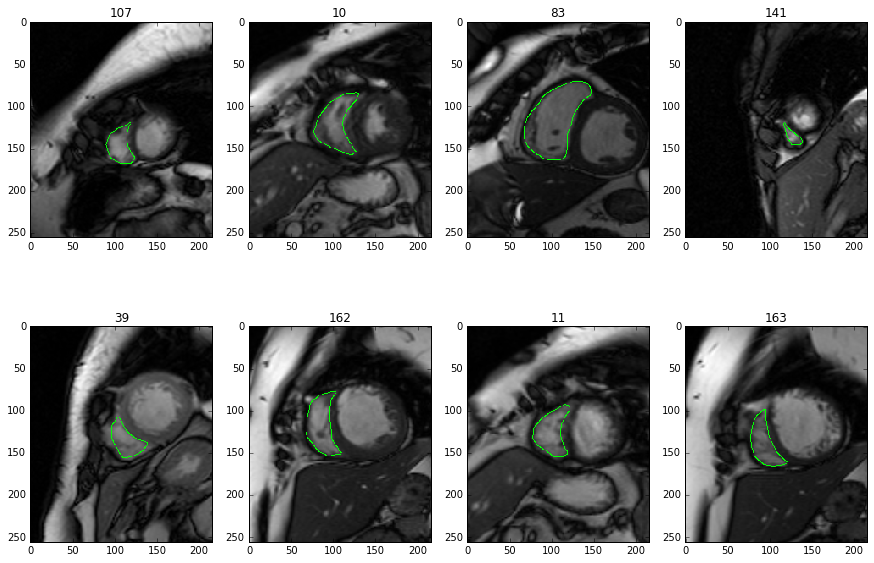

In [4]:
# load train data
X_train,Y_train=misc.load_data(path2nfolds + 'trainfold'+str(foldnm)+'.npz')


n1=misc.disp_img_mask(X_train,Y_train,2,4,2)


In [5]:
#misc.disp_hist(X_train,n1,2,4,2)

__________________________________________________
please wait to load data ...
('X shape: ', (256, 216, 57))
('Y shape: ', (256, 216, 57))
('Min and Max X: ', 0, 1060)
('Min and Max Y: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


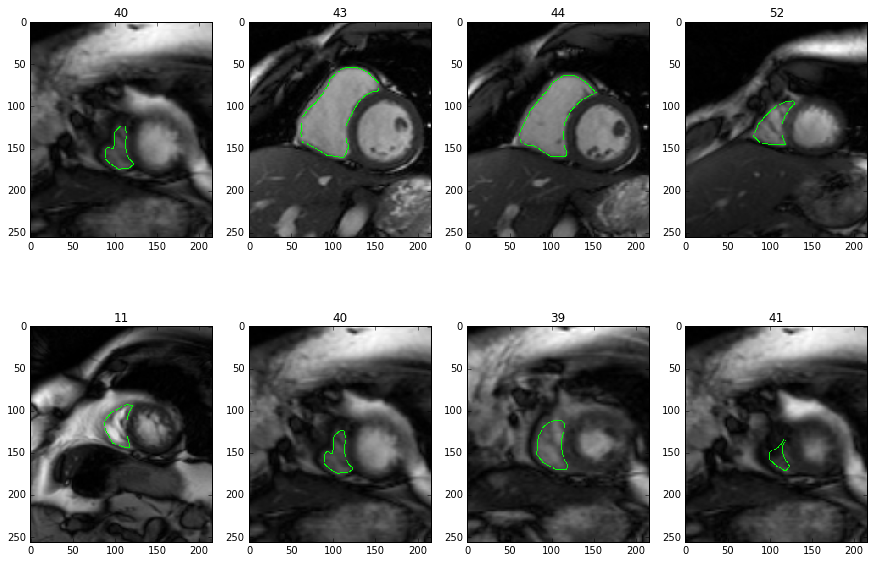

In [6]:
# load test data
X_test,Y_test=misc.load_data(path2nfolds + 'testfold'+str(foldnm)+'.npz')

n2=misc.disp_img_mask(X_test,Y_test,2,4,2)

In [7]:
#misc.disp_hist(X_train,n2,2,4,2)

__________________________________________________
__________________________________________________
please wait ...
Elapsed time: 0 seconds
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r size: ', (186, 1, 192, 192))
('Min and Max  X_r: ', -1.4898733, 8.357584)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


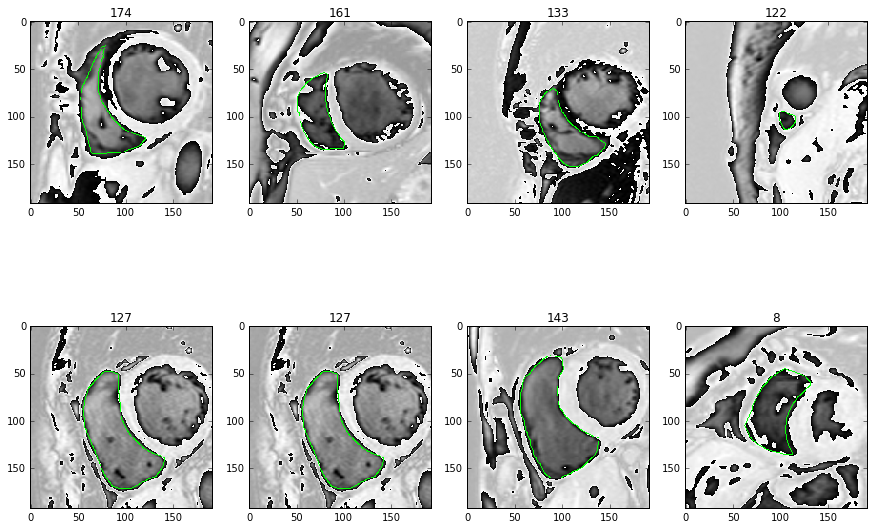

In [8]:
# preprocess train data     
params_preprocess={
    'row' : 192,
    'col' : 192,
    'imr' : 1,
    'crop': True,
    'crop_type': 'random',
    'normalization':True,
    }

# pre processing 
X_train_r,Y_train_r=misc.preprocess(X_train,Y_train,params_preprocess)

# display sample image
n1=misc.disp_img_mask(X_train_r,Y_train_r,2,4)

In [9]:
#misc.disp_hist(X_train_r,n1,2,4,0)

__________________________________________________
please wait to resize images ...
('X_r size: ', (57, 1, 192, 192))
('Y_r size: ', (57, 1, 192, 192))
('Min and Max  X_r: ', -1.5070901, 10.843662)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


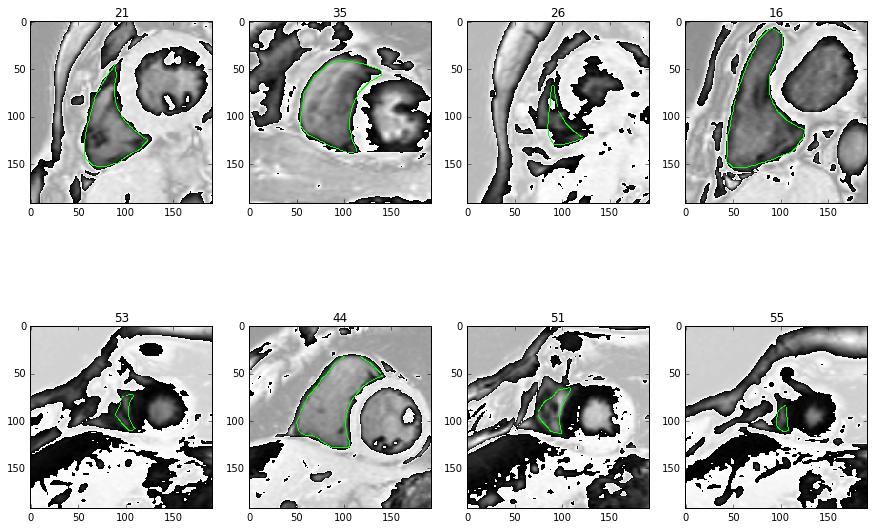

In [10]:
# preprocess test data     
params_preprocess={
    'row' : 192,
    'col' : 192,
    'imr' : 1,
    'crop': True,
    'crop_type': 'center',
    'normalization':True,
    }

# preprocess test data
X_test_r,Y_test_r=misc.preprocess(X_test,Y_test,params_preprocess)

# display sample image
n2=misc.disp_img_mask(X_test_r,Y_test_r,2,4)

In [11]:
#misc.disp_hist(X_test_r,n2,2,4,0)

In [12]:
# training params
params_train={
        'row': X_train_r.shape[2],
        'col': X_train_r.shape[3],           
        'weights': None,        
        'learning_rate': 1e-4,
        'optimizer': 'Adam',
        'loss': 'dice',
        'nbepoch': 1000
        }


# build the model
model = cnn_model(params_train)
model.summary()


output:  (None, 128, 12, 12)
output:  (None, 128, 24, 24)
output:  (None, 64, 48, 48)
output:  (None, 32, 96, 96)
output:  (None, 16, 192, 192)
output:  (None, 1, 192, 192)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 192, 192)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 192, 192)  160         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 96, 96)    2320        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Co

In [13]:
# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=75,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=0.01,
        channel_shift_range=0.0,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        dim_ordering='th') 

def iterate_minibatches(inputs1 , targets,  batchsize, shuffle=True, augment=True):
    assert len(inputs1) == len(targets)
 
    if shuffle:
        indices = np.arange(len(inputs1))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs1) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        x = inputs1[excerpt]
        y = targets[excerpt] 
        for  xxt,yyt in datagen.flow(x, y , batch_size=x.shape[0]):
            x = xxt.astype(np.float32) 
            y = yyt 
            break

    #yield x, np.array(y, dtype=np.uint8)         
    return x, np.array(y, dtype=np.uint8)         

X_train_aug,Y_train_aug=iterate_minibatches( X_train_r, Y_train_r , X_train_r.shape[0], shuffle=True)

array([ 99, 125, 164,  55, 105,  13,  13, 114])

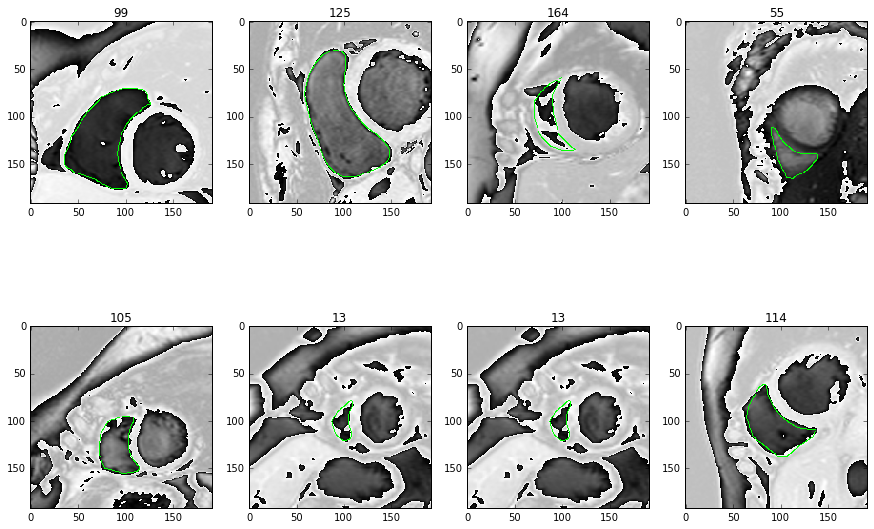

In [ ]:
# display sample image after augmentation
misc.disp_img_mask(X_train_r,Y_train_r,2,4)

In [ ]:
print 'training in progress ...'

# checkpoint
weightfolder='./output/weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2weights=weightfolder+"/weights.hdf5"
checkpoint = ModelCheckpoint(path2weights, monitor='val_loss', verbose=1, save_best_only='True',mode='min')

# path to csv file to save scores
path2scorescsv = weightfolder+'/scores.csv'
first_row = 'train,test'
with open(path2scorescsv, 'w+') as f:
    f.write(first_row + '\n')


# Fit the model
start_time=time.time()
scores=[]
scores_train=[]
for e in range(params_train['nbepoch']):
    print 'epoch: %s' %e
    seed = np.random.randint(0, 999999)
    X_train_r,Y_train_r=misc.preprocess(X_train,Y_train,params_preprocess)
    X_train_aug,Y_train_aug=iterate_minibatches( X_train_r, Y_train_r , X_train_r.shape[0], shuffle=True)
    model.fit(X_train_aug, Y_train_aug, validation_data=(X_test_r, Y_test_r), nb_epoch=1, batch_size=8,verbose=1,shuffle=True,callbacks=[checkpoint])
    score=model.evaluate(X_test_r, Y_test_r)    
    score_train=model.evaluate(X_train_r, Y_train_r)    
    scores=np.append(scores,score[1])
    scores_train=np.append(scores_train,score_train[1])    
    
   # store scores into csv file
    with open(path2scorescsv, 'a') as f:
        string = str([score_train,score])
        f.write(string + '\n')
    
    
print 'model was trained!'
elapsed_time=(time.time()-start_time)/60
print 'elapsed time: %d  mins' %elapsed_time


training in progress ...
epoch: 0
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r size: ', (186, 1, 192, 192))
('Min and Max  X_r: ', -1.6156638, 9.9224939)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________
Train on 186 samples, validate on 57 samples
Epoch 1/1
186/186 [==============================] - 0s     
epoch: 1
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r size: ', (186, 1, 192, 192))
('Min and Max  X_r: ', -1.6156638, 9.9224939)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________
Train on 186 samples, validate on 57 samples
Epoch 1/1
186/186 [==============================] - 0s     
epoch: 2
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r siz

best test score 0.82278214944


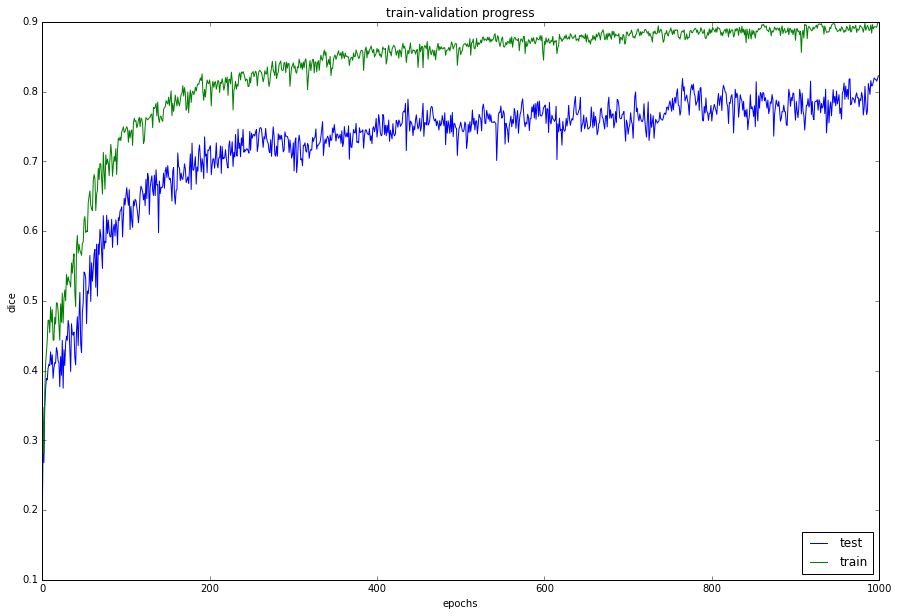

In [20]:
plt.plot(scores)
plt.plot(scores_train)
plt.title('train-validation progress')
plt.legend(('test','train'), loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('dice')
print 'best test score', np.max(scores)

In [23]:
print 'please wait to test ...'
model.load_weights(path2weights)
print 'weights loaded!'

# predic training data
print '-' *50
print 'please wait to test ...'
Y_train_pred=model.predict(X_train_r)
DM_train=misc.calc_dice(Y_train_r,Y_train_pred)
print 'Train data Dice Metric: %0.2f' %DM_train



please wait to test ...
weights loaded!
--------------------------------------------------
please wait to test ...
processing 0, dice= 0.96
processing 1, dice= 0.96
processing 2, dice= 0.93
processing 3, dice= 0.97
processing 4, dice= 0.95
processing 5, dice= 0.95
processing 6, dice= 0.95
processing 7, dice= 0.95
processing 8, dice= 0.91
processing 9, dice= 0.93
processing 10, dice= 0.90
processing 11, dice= 0.93
processing 12, dice= 0.88
processing 13, dice= 0.78
processing 14, dice= 0.83
processing 15, dice= 0.63
processing 16, dice= 0.95
processing 17, dice= 0.96
processing 18, dice= 0.93
processing 19, dice= 0.94
processing 20, dice= 0.93
processing 21, dice= 0.92
processing 22, dice= 0.89
processing 23, dice= 0.91
processing 24, dice= 0.89
processing 25, dice= 0.89
processing 26, dice= 0.86
processing 27, dice= 0.70
processing 28, dice= 0.58
processing 29, dice= 0.98
processing 30, dice= 0.97
processing 31, dice= 0.95
processing 32, dice= 0.95
processing 33, dice= 0.94
processing 

In [24]:
# predic test data
print '-' *50
print 'please wait to test ...'
Y_test_pred=model.predict(X_test_r)
DM_test=misc.calc_dice(Y_test_r,Y_test_pred)
print 'Test data Dice Metric: %0.2f' %DM_test


--------------------------------------------------
please wait to test ...
processing 0, dice= 0.85
processing 1, dice= 0.81
processing 2, dice= 0.66
processing 3, dice= 0.89
processing 4, dice= 0.81
processing 5, dice= 0.85
processing 6, dice= 0.64
processing 7, dice= 0.64
processing 8, dice= 0.58
processing 9, dice= 0.70
processing 10, dice= 0.51
processing 11, dice= 0.54
processing 12, dice= 0.00
processing 13, dice= 0.64
processing 14, dice= 0.33
processing 15, dice= 0.77
processing 16, dice= 0.42
processing 17, dice= 0.63
processing 18, dice= 0.83
processing 19, dice= 0.75
processing 20, dice= 0.84
processing 21, dice= 0.03
processing 22, dice= 0.44
processing 23, dice= 0.10
processing 24, dice= 0.54
processing 25, dice= 0.52
processing 26, dice= 0.62
processing 27, dice= 0.66
processing 28, dice= 0.75
processing 29, dice= 0.55
processing 30, dice= 0.43
processing 31, dice= 0.46
processing 32, dice= 0.83
processing 33, dice= 0.53
processing 34, dice= 0.84
processing 35, dice= 0.85

__________________________________________________
please wait to resize images ...
('X_r size: ', (57, 1, 192, 192))
('Y_r size: ', (57, 1, 192, 192))
('Min and Max  X_r: ', 0.0, 835.0)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


array([47, 20, 24, 47,  8, 24, 42, 23, 13, 20,  5,  9, 18, 39, 27, 52, 39,
       46])

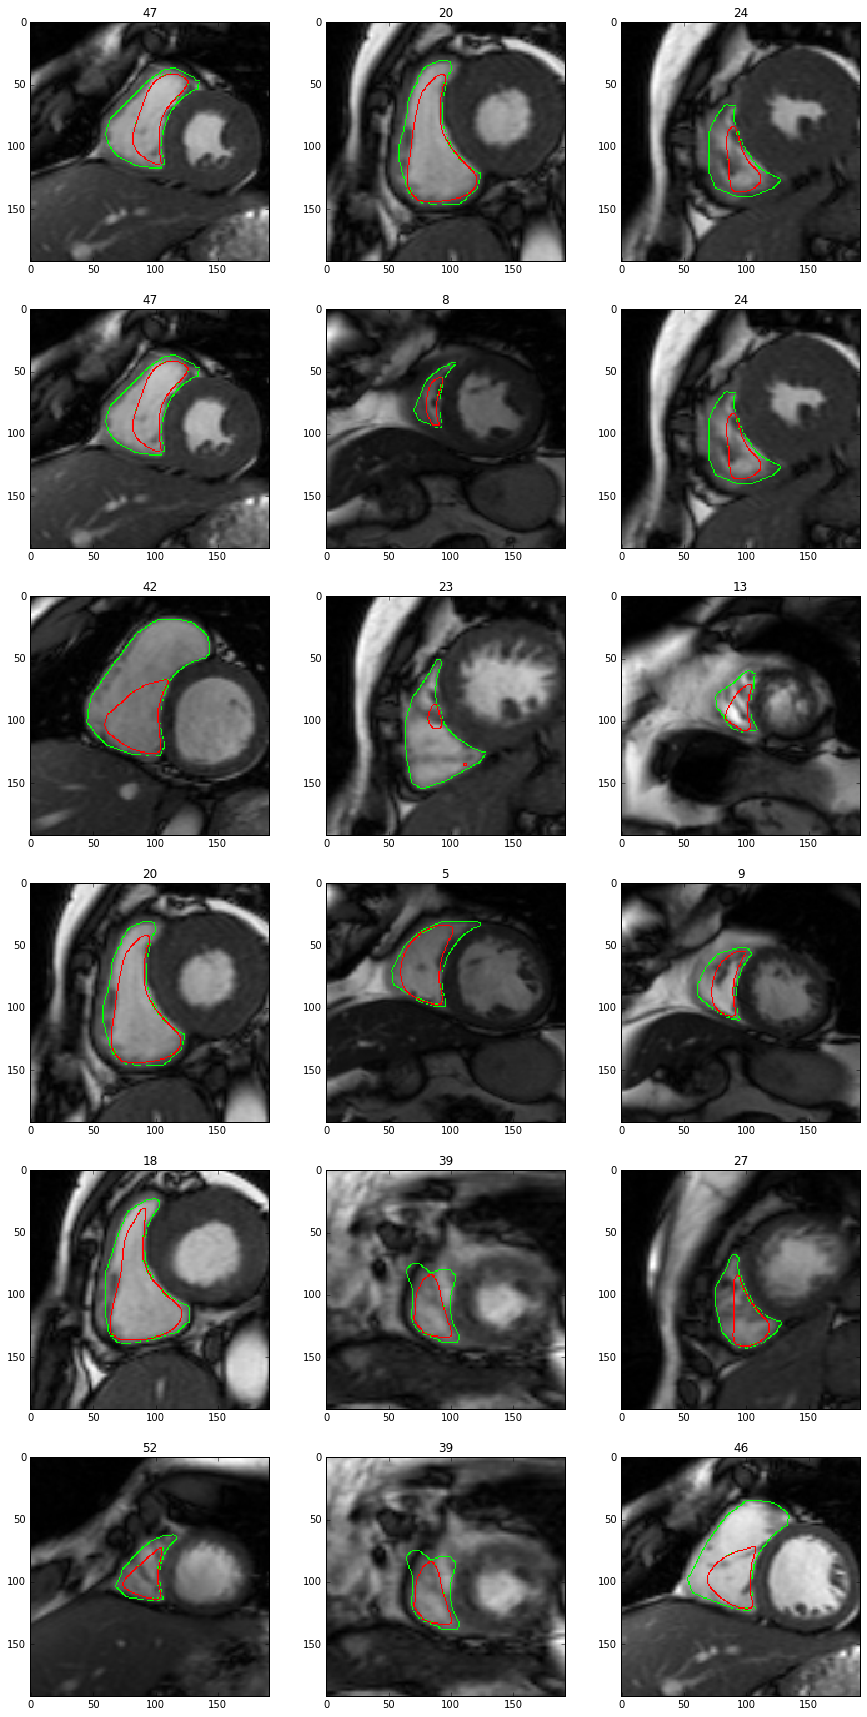

In [25]:
# preprocess test data     
params_preprocess={
    'row' : 192,
    'col' : 192,
    'imr' : 1,
    'crop': True,
    'crop_type': 'center',
    'normalization':False,
    }
# preprocess test data
X_test_r,Y_test_r=misc.preprocess(X_test,Y_test,params_preprocess)
plt.figure(figsize=(15,30))
misc.disp_img_mask(X_test_r,Y_test_r+Y_test_pred,6,3)